#### Set-up

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.patheffects as pe
from matplotlib.lines import Line2D

In [103]:
from ema_workbench import load_results, save_results
from ema_workbench.analysis import clusterer, plotting, Density

In [104]:
from plotting import save_fig

In [105]:
sns.set_style('white')

In [106]:
no_flood = False

nfl = ""
if no_flood:
    nfl = "no_flood/"

In [107]:
path = f'../results/{nfl}'
file_name = '2000_scen__AGGD_reps__0612__burned_in__with_rates'
file_ext  = '.tar.gz'

In [108]:
experiments, outcomes = load_results(path+file_name+file_ext)

In [109]:
[key for key in outcomes]

['Household Population',
 'STD[Household Population]',
 'VAR[Household Population]',
 '95CI_LO[Household Population]',
 '95CI_HI[Household Population]',
 'Gini Coefficient',
 'STD[Gini Coefficient]',
 'VAR[Gini Coefficient]',
 '95CI_LO[Gini Coefficient]',
 '95CI_HI[Gini Coefficient]',
 'Median Wage',
 'STD[Median Wage]',
 'VAR[Median Wage]',
 '95CI_LO[Median Wage]',
 '95CI_HI[Median Wage]',
 'GDP',
 'STD[GDP]',
 'VAR[GDP]',
 '95CI_LO[GDP]',
 '95CI_HI[GDP]',
 'Change in Household Population',
 'STD[Change in Household Population]',
 'VAR[Change in Household Population]',
 '95CI_LO[Change in Household Population]',
 '95CI_HI[Change in Household Population]',
 'Change in GDP',
 'STD[Change in GDP]',
 'VAR[Change in GDP]',
 '95CI_LO[Change in GDP]',
 '95CI_HI[Change in GDP]',
 'Change in Gini Coefficient',
 'STD[Change in Gini Coefficient]',
 'VAR[Change in Gini Coefficient]',
 '95CI_LO[Change in Gini Coefficient]',
 '95CI_HI[Change in Gini Coefficient]',
 'Change in Median Wage',
 'STD[Ch

In [110]:
oois = [out for out in outcomes if out.count('[') == 0]
oois.extend([f'VAR[{out}]' for out in oois if 'Change' not in out])
oois

['Household Population',
 'Gini Coefficient',
 'Median Wage',
 'GDP',
 'Change in Household Population',
 'Change in GDP',
 'Change in Gini Coefficient',
 'Change in Median Wage',
 'VAR[Household Population]',
 'VAR[Gini Coefficient]',
 'VAR[Median Wage]',
 'VAR[GDP]']

### Univariate Clustering

1. ([This Notebook](Timeseries%20Clustering.ipynb)) For each major outcome of interest, perform time-series clustering. Do this for multiple k-values (# of clusters) and compare results, similar to Jafino & Kwakkel (2021). Select optimal k-number for each outcome.
2. ([Cluster Analysis](Cluster%20Analysis.ipynb)) Plot (using a matrix) the co-occurrence of clusters across different variables to see if there are noticeable patterns.
3. ([Cluster Rule Induction](Cluster%20Rule%20Induction.ipynb)) Perform PRIM (for now) on each cluster, for each variable, to look for predictive/explanatory input spaces. Stick to the input spaces (for now).

Other notes:
* Test it with both the full time-series and with cutting off the first 20 steps (burn-in).

#### Calculate Complex-Invariate Distances

As a benchmark, this took 21 minutes to find the distances in 3 outcomes for a 10000-scenario run.

In [111]:
distances = {}

In [112]:
for ooi in oois:
    # Calculate TS distances
    data = outcomes[ooi]
    distances[ooi] = clusterer.calculate_cid(data)
    
    # NB: Saving the distances requires A LOT of disk space.
    #      Specifically, num_runs^2*64 bits. For 10k runs, that's 6.4 GB.
    # pd.DataFrame(distances).to_csv("../results/clustering_distances/10k_run_0605__household_population__distances.csv")

#### Compute clusters for a range of K-values

For each one, calculate the *explained variance*, as well as the *increase in explained variance gained by moving from K=k-1 to K=k*.

In [113]:
min_K = 2
max_K = 21 

In [114]:
all_clusters = {ooi:{} for ooi in oois}
explained_variances = {ooi:{} for ooi in oois}
delta_EVs = {ooi:{} for ooi in oois}

for ooi in oois:
    # Calculate overall centroid
    overall_centroid = outcomes[ooi].mean(axis=0)
    # Calculate sum mean squared error for total dataset
    assert(len(outcomes[ooi][0]) == len(overall_centroid))
    MSEs_all = [np.power(run - overall_centroid, 2).mean() for run in outcomes[ooi]]

    SMSE_all = sum(MSEs_all)
    # print(f"{ooi} has overall SMSE of {SMSE_all:.3}")

    # Test across K values (candidate #s of clusters)
    prev_EV = 0
    for K in range(min_K, max_K): 
        # Compute clusters
        all_clusters[ooi][K] = clusterer.apply_agglomerative_clustering(distances[ooi], n_clusters=K)

        # Calculate within-cluster error (sum mean squared error)
        runs_by_cluster = [[] for clust in range(K)]
        for n, run in enumerate(outcomes[ooi]):
            clust = all_clusters[ooi][K][n]
            runs_by_cluster[clust].append(run)
        runs_by_cluster = [np.array(runs) for runs in runs_by_cluster]

        SMSEs_within = []
        for clust in range(K):
            runs = runs_by_cluster[clust]
            clust_centroid = runs.mean(axis=0)
            MSEs_within = [np.power(run - clust_centroid, 2).mean() for run in runs]
            SMSEs_within.append(sum(MSEs_within))

        explained_variances[ooi][K] = 1 - (sum(SMSEs_within) / SMSE_all)

        delta_EVs[ooi][K] = explained_variances[ooi][K] - prev_EV
        prev_EV = explained_variances[ooi][K]
        # print(f":: K={K} produces within-cluster SMES of {SMSEs_within}")
        # print(f":: K={K} produces explained variance EV_K={explained_variances[ooi][K]}")


#### Plot elbow curves to visualize cluster performance convergence

In [115]:
# Reconfigure data into plot-friendly format
index = [K for K in range(min_K, max_K)]

# ALT METHOD: Produces separate DF per OOI.
# dfs = {}
# for ooi in oois:
#     # EV_as_list = [EV for _, EV in explained_variances[ooi].items()]
#     # delta_EV_as_list = [d_EV for _, d_EV in delta_EVs[ooi].items()]

#     dfs[ooi] = pd.DataFrame({
#             'Explained variance':[EV for _, EV in explained_variances[ooi].items()],
#             'Change in explained variance':[d_EV for _, d_EV in delta_EVs[ooi].items()]
#         },
#         index=index
#     )

# PREFERRED METHOD: Produces one DF for EV and one for delta_EV.
EV_lists = {ooi:[EV for _, EV in explained_variances[ooi].items()] for ooi in oois}
delta_EV_lists = {ooi:[d_EV for _, d_EV in delta_EVs[ooi].items()] for ooi in oois}

EV_lists['K'] = delta_EV_lists['K'] = index

EV_df = pd.DataFrame(EV_lists)
delta_EV_df = pd.DataFrame(delta_EV_lists)

In [116]:
explained_variances.keys()

dict_keys(['Household Population', 'Gini Coefficient', 'Median Wage', 'GDP', 'Change in Household Population', 'Change in GDP', 'Change in Gini Coefficient', 'Change in Median Wage', 'VAR[Household Population]', 'VAR[Gini Coefficient]', 'VAR[Median Wage]', 'VAR[GDP]'])

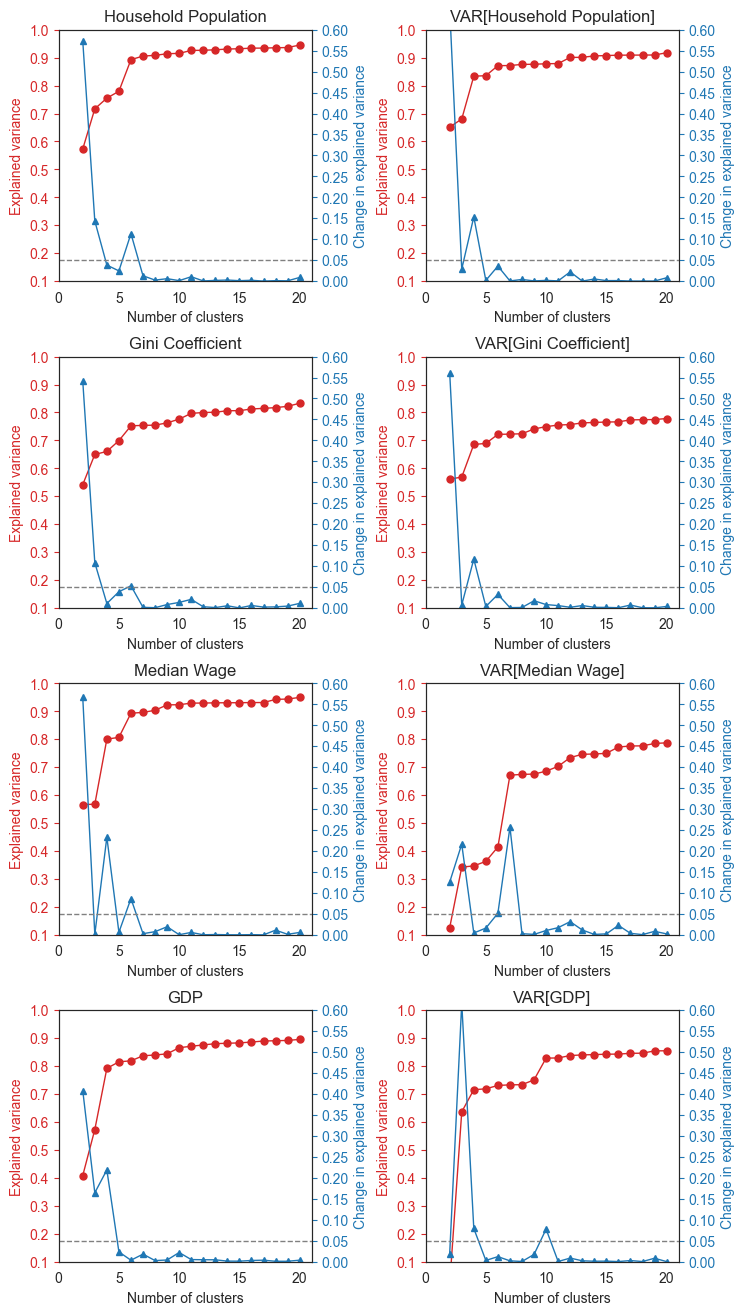

In [117]:
# Plot! 
main_oois = [out for out in outcomes if out.count('[') == 0 and 'Change' not in out]
# ooi_types = ['', 'Change in ', 'VAR[]']
ooi_types = ['', 'VAR[]']

n_rows = len(main_oois)
n_cols = len(ooi_types)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for row, ooi_name in enumerate(main_oois):
    for col, ooi_type in enumerate(ooi_types):
        if ooi_type == 'VAR[]':
            ooi = f'VAR[{ooi_name}]'
        else:
            ooi = ooi_type + ooi_name
 
        # Create plot with two y-axes
        ax1 = axes[row][col]
        ax2 = ax1.twinx()

        # Set up x-axis
        ax1.set_xlim([0, max_K])
        ax1.set_xticks([K for K in range(0, max_K, 5)])
        ax1.set_xlabel('Number of clusters')

        # Plot EV and set up its axis
        ax1.plot(index, EV_df[ooi], 'o-', color='tab:red', linewidth=1, markersize=5)
        ax1.set_ylim([0.1, 1.0])
        ax1.set_ylabel('Explained variance', color='tab:red')
        ax1.set_yticks([(i+1)/10 for i in range(10)])
        ax1.tick_params(axis='y', color='tab:red', labelcolor='tab:red')

        # Plot delta_EV and set up its axis
        ax2.plot(index, delta_EV_df[ooi], '^-', color="tab:blue", linewidth=1, markersize=5)
        ax2.set_ylim([0, 0.6])
        ax2.set_ylabel('Change in explained variance', color='tab:blue')
        ax2.set_yticks([(i)/20 for i in range(13)])
        ax2.tick_params(axis='y', color='tab:blue', labelcolor='tab:blue')

        # Add elbow cut-off point
        ax2.hlines(y=0.05, xmin=0, xmax=max_K, colors='grey', linestyles={'dashed'}, linewidth=1)

        # Add title to subplot
        ax1.set_title(f'{ooi}')

plt.subplots_adjust(wspace=0.45, hspace=0.3)
# Final steps
save_fig(title='explained variances', dir=f'{nfl}clustering')

plt.show()

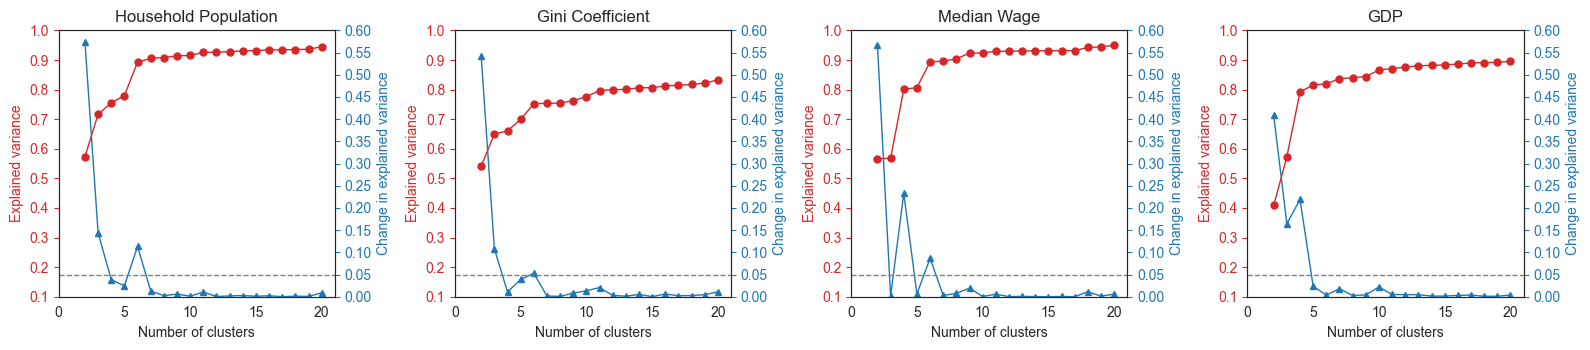

In [118]:
# Plot! 
main_oois = [out for out in outcomes if out.count('[') == 0 and 'Change' not in out]

n_cols = 4
n_rows = len(main_oois) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.6*n_rows))

for i, ooi in enumerate(main_oois):
    
    if n_rows == 1: 
        ax1 = axes[i]
    else:
        row = i // 2
        col = i % 2
        ax1 = axes[row][col]

    # Create plot with two y-axes
    ax2 = ax1.twinx()

    # Set up x-axis
    ax1.set_xlim([0, max_K])
    ax1.set_xticks([K for K in range(0, max_K, 5)])
    ax1.set_xlabel('Number of clusters')

    # Plot EV and set up its axis
    ax1.plot(index, EV_df[ooi], 'o-', color='tab:red', linewidth=1, markersize=5)
    ax1.set_ylim([0.1, 1.0])
    ax1.set_ylabel('Explained variance', color='tab:red')
    ax1.set_yticks([(i+1)/10 for i in range(10)])
    ax1.tick_params(axis='y', color='tab:red', labelcolor='tab:red')

    # Plot delta_EV and set up its axis
    ax2.plot(index, delta_EV_df[ooi], '^-', color="tab:blue", linewidth=1, markersize=5)
    ax2.set_ylim([0, 0.6])
    ax2.set_ylabel('Change in explained variance', color='tab:blue')
    ax2.set_yticks([(i)/20 for i in range(13)])
    ax2.tick_params(axis='y', color='tab:blue', labelcolor='tab:blue')

    # Add elbow cut-off point
    ax2.hlines(y=0.05, xmin=0, xmax=max_K, colors='grey', linestyles={'dashed'}, linewidth=1)

    # Add title to subplot
    ax1.set_title(f'{ooi}')

plt.subplots_adjust(wspace=0.45, hspace=0.3)
# Final steps
plt.tight_layout()
save_fig(title='explained variances just oois', dir=f'{nfl}clustering')

plt.show()

#### Select optimal K and save results to a file

In [119]:
for ooi in oois:
    for K in range(min_K+1, max_K):
        if ooi == 'Household Population':
            if (no_flood and K == 7) or (not no_flood and K == 6):
                experiments[f"Cluster ({ooi})"] = all_clusters[ooi][K].astype("object")
                break
        elif delta_EVs[ooi][K] < 0.05:
            experiments[f"Cluster ({ooi})"] = all_clusters[ooi][K-1].astype("object")
            break

In [120]:
experiments['Cluster (Household Population)'].max()

5

experiments.head()

In [91]:
results = experiments, outcomes
save_results(results, path+file_name+'__with_clusters__K7'+file_ext)

c:\Users\Gabriel\Documents\Academic\EPA\2. Thesis\Code\CRAB_EM\.venv\Lib\site-packages\ema_workbench\em_framework\outcomes.py:540: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")


### Selecting Representative Scenarios

In [92]:
experiments.head(3)

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model,Cluster (Household Population),Cluster (Gini Coefficient),Cluster (Median Wage),Cluster (GDP),Cluster (VAR[Household Population]),Cluster (VAR[Gini Coefficient]),Cluster (VAR[Median Wage]),Cluster (VAR[GDP])
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,CRAB,2,0,2,0,0,0,0,0
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,CRAB,1,2,2,3,3,0,0,0
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,CRAB,3,1,1,2,2,1,0,2


In [121]:
representative_scenarios = {ooi:[] for ooi in oois}
for ooi in oois:
    # Separate runs for each cluster in this variable
    n_clusters = experiments[f'Cluster ({ooi})'].astype(np.int64).max() + 1
    runs_by_cluster = [[] for cluster in range(n_clusters)]
    for n, run in enumerate(outcomes[ooi]):
        cluster = experiments[f'Cluster ({ooi})'][n]
        runs_by_cluster[cluster].append(run)
        
    runs_by_cluster = [np.array(runs) for runs in runs_by_cluster]

    for cluster in range(n_clusters):
        # Calculate MSE for each run from cluster center
        runs = runs_by_cluster[cluster]
        clust_centroid = runs.mean(axis=0)
        MSEs_within = [np.power(run - clust_centroid, 2).mean() for run in runs]

        # Select run with lowest MSE
        rbc_index = np.argmin(MSEs_within)

        # Find associated scenario
        scenario = experiments[experiments[f'Cluster ({ooi})'] == cluster].iloc[rbc_index].name
        assert (runs_by_cluster[cluster][rbc_index] == outcomes[ooi][scenario]).all()
        
        # Save representative scenario for this cluster
        representative_scenarios[ooi].append(scenario)

In [ ]:
representative_scenarios

{'Household Population': [1625, 740, 161, 1512, 1358, 1337],
 'Gini Coefficient': [485, 1288, 124],
 'Median Wage': [362, 380],
 'GDP': [907, 466, 1907, 336],
 'Change in Household Population': [1528, 933, 1183],
 'Change in GDP': [1850, 1138],
 'Change in Gini Coefficient': [1253, 668],
 'Change in Median Wage': [123, 989, 562],
 'VAR[Household Population]': [1540, 675],
 'VAR[Gini Coefficient]': [295, 352],
 'VAR[Median Wage]': [1206, 1871, 1018],
 'VAR[GDP]': [271, 338, 436, 342]}

In [79]:
# TODO: Save all sets of represntative scenarios (should have 4 sets: flood k3, flood k6, noflood k3, noflood k7)

### Plotting by cluster

In [139]:
experiments, outcomes = load_results('../results/2000_scen__AGGD_reps__0612__burned_in__with_rates__with_clusters.tar.gz')

In [140]:
# experiments, outcomes = results

In [141]:
cluster_palette = sns.color_palette("tab10", 10)

In [142]:
rgba_palette = []
for clr in cluster_palette:
    rgba_palette.append((clr[0], clr[1], clr[2], 0.75))

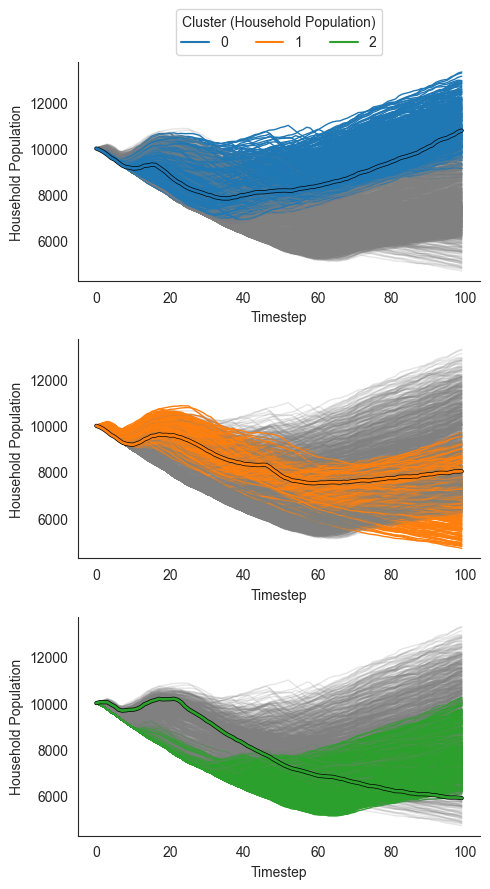

In [148]:
for ooi in ['Household Population']: # oois:
    # Set up plot
    n_clusters = experiments[f'Cluster ({ooi})'].astype(np.int64).max() + 1
    # if (n_clusters == 3 or n_clusters > 4):
    #     n_cols = 3
    # else:
    #     n_cols = 2

    n_cols = 1

    if n_cols > 1:
        n_rows = (n_clusters+1) // n_cols
    else:
        n_rows = n_clusters
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
    
    if n_rows == 1:
        axes = [axes]

    # Add lines
    for cluster in range(n_clusters):
        row = cluster // n_cols
        col = cluster % n_cols
        
        if n_cols > 1:
            ax = axes[row][col]
        else: 
            ax = axes[row]

        runs = outcomes[ooi] #[experiments[experiments[f'Cluster ({ooi})'] == cluster].index]
        for i, run in enumerate(runs):
            color = cluster_palette[cluster] if experiments.loc[i, f'Cluster ({ooi})'] == cluster else (0.5,0.5,0.5,0.2)
            ax.plot(run, color=color, linewidth=1)

        # Replot representative run on top
        rep_run_idx = representative_scenarios[ooi][cluster]
        ax.plot(outcomes[ooi][rep_run_idx],
                color=cluster_palette[cluster],
                linewidth=2,
                path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]
        )

        # Add labels
        ax.set_xlabel('Timestep')
        ax.set_ylabel(ooi)
    
    # Finalize plot
    if n_clusters % n_cols != 0:
        fig.delaxes(axes[n_rows-1, 1])
    sns.despine()

    
    # Create legend
    handles = []
    for cluster in range(n_clusters):
        color = cluster_palette[cluster]
        handles.append(Line2D(
            [], [], color=color, linestyle='solid', label=cluster,
        ))
    if n_cols == 3:
        ax = axes[0][0]
        bbox_anchor = (0.5, 0.99)
    elif n_cols == 2:
        ax = axes[0][0]
        bbox_anchor = (1, 1)
    elif n_cols == 1:
        ax = axes[0]
        bbox_anchor = (0.5, 1)
    legend = ax.legend(
        title=f'Cluster ({ooi})',
        handles=handles,
        bbox_to_anchor=bbox_anchor,
        loc='lower center',
        ncol=n_clusters,
    )
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((1,1,1,0))
    # legend.get_frame().set_edgecolor((1,1,1,0))

    plt.tight_layout()
    save_fig(title=f'{ooi}_ timeseries by cluster_ 2 col', dir=f'{nfl}clustering')
    plt.show()

In [144]:
# for ooi in oois:
#     # Set up plot
#     plt.figure(figsize=(12, 6))

#     # Add lines
#     n_clusters = experiments[f'Cluster ({ooi})'].astype(np.int64).max() + 1

#     for cluster in range(n_clusters):
#         runs = outcomes[ooi][experiments[experiments[f'Cluster ({ooi})'] == cluster].index]
#         first = True
#         for run in runs:
#             label = f'Cluster {cluster}' if first else None
#             plt.plot(run, color=rgba_palette[cluster], linewidth=1, label=label)
#             first = False
    
#     # Finalize plot
#     sns.despine()
#     plt.title(f'{n_clusters} Clusters of {ooi}')
#     plt.xlabel('Timestep')
#     plt.ylabel(ooi)
#     plt.legend()
#     plt.show()